In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
data = pd.read_csv('ethereum_daily_data_2018_2024.csv')
data.head()

,time,Open,High,Low,Close,Volume
0,2018-01-01,741.69,766.49,718.90,757.22,910875.63
1,2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2,2018-01-03,861.97,951.70,847.90,941.10,871172.13
3,2018-01-04,941.00,997.44,901.03,944.83,822844.78
4,2018-01-05,944.50,1165.81,926.75,963.88,1682729.53


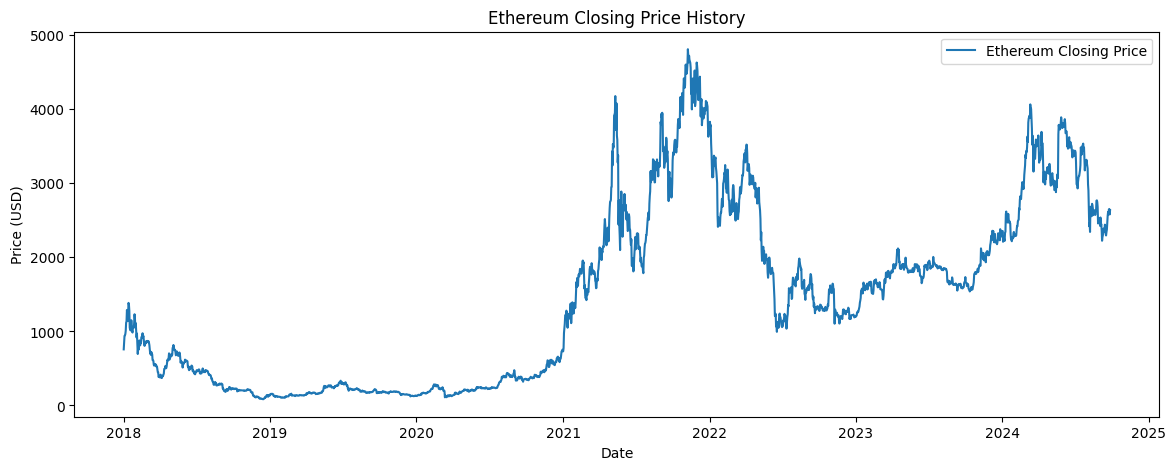

In [ ]:
data['time'] = pd.to_datetime(data['time'])

data.set_index('time', inplace=True)

plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Ethereum Closing Price')
plt.title('Ethereum Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
data['Seconds'] = data.index.map(pd.Timestamp.timestamp)
data.head()

,Open,High,Low,Close,Volume,Seconds
time,,,,,,
2018-01-01,741.69,766.49,718.90,757.22,910875.63,1.514765e+09
2018-01-02,756.17,882.61,756.17,861.97,1123318.86,1.514851e+09
2018-01-03,861.97,951.70,847.90,941.10,871172.13,1.514938e+09
2018-01-04,941.00,997.44,901.03,944.83,822844.78,1.515024e+09
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53,1.515110e+09


In [ ]:
day = 60 * 60 * 24
year = 365.2425 * day

data['Day sin'] = np.sin(data['Seconds'] * (2* np.pi / day))
data['Day cos'] = np.cos(data['Seconds'] * (2 * np.pi / day))
data['Year sin'] = np.sin(data['Seconds'] * (2 * np.pi / year))
data['Year cos'] = np.cos(data['Seconds'] * (2 * np.pi / year))
data.head()

,Open,High,Low,Close,Volume,Seconds,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,
2018-01-01,741.69,766.49,718.90,757.22,910875.63,1.514765e+09,-2.389847e-12,1.0,0.006193,0.999981
2018-01-02,756.17,882.61,756.17,861.97,1123318.86,1.514851e+09,-1.264322e-11,1.0,0.023394,0.999726
2018-01-03,861.97,951.70,847.90,941.10,871172.13,1.514938e+09,-8.344685e-12,1.0,0.040587,0.999176
2018-01-04,941.00,997.44,901.03,944.83,822844.78,1.515024e+09,-4.046146e-12,1.0,0.057769,0.998330
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53,1.515110e+09,2.523923e-13,1.0,0.074934,0.997189


In [ ]:
data = data.drop('Seconds', axis = 1)
data.head()

,Open,High,Low,Close,Volume,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,
2018-01-01,741.69,766.49,718.90,757.22,910875.63,-2.389847e-12,1.0,0.006193,0.999981
2018-01-02,756.17,882.61,756.17,861.97,1123318.86,-1.264322e-11,1.0,0.023394,0.999726
2018-01-03,861.97,951.70,847.90,941.10,871172.13,-8.344685e-12,1.0,0.040587,0.999176
2018-01-04,941.00,997.44,901.03,944.83,822844.78,-4.046146e-12,1.0,0.057769,0.998330
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53,2.523923e-13,1.0,0.074934,0.997189


In [ ]:
features = ['Close', 'Day sin', 'Day cos', 'Year sin', 'Year cos']

train_size = int(len(data) * 0.8)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data.iloc[:train_size][features].values)

scaled_all = scaler.transform(data[features].values)

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length, 0]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 60

train_data = scaled_all[:train_size]
test_data = scaled_all[train_size - sequence_length:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1909, 60, 5)
y_train shape: (1909,)
X_test shape: (493, 60, 5)
y_test shape: (493,)


In [ ]:
model = Sequential()
model.add(Input(shape=(60, 5)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0349 - val_loss: 0.0045
Epoch 2/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 3/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 4/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 5/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 6/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 9/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 10/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 11/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 12/70
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

In [ ]:
n_features = len(features)  # 5

# Funzione per invertire solo la colonna Close
def inverse_scale_close(y_scaled, scaler, n_features=n_features):
    y_scaled = np.asarray(y_scaled).reshape(-1)
    arr = np.zeros((len(y_scaled), n_features))
    arr[:, 0] = y_scaled  # Close è la prima colonna
    inv = scaler.inverse_transform(arr)
    return inv[:, 0]

# Predizioni scalate (output dal modello)
predictions_scaled = model.predict(X_test).reshape(-1)

# Inverse scaling
predictions = inverse_scale_close(predictions_scaled, scaler, n_features=n_features)
y_true      = inverse_scale_close(y_test, scaler, n_features=n_features)

# MAE
mae = mean_absolute_error(y_true, predictions)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, predictions))

# MAPE (con protezione contro divisioni per zero)
mape = np.mean(np.abs((y_true - predictions) / np.clip(y_true, 1e-10, None))) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Absolute Error (MAE): 119.34
Root Mean Squared Error (RMSE): 159.37
Mean Absolute Percentage Error (MAPE): 4.37%


In [ ]:
last_seq = data[features].iloc[-sequence_length:].values

if np.isnan(last_seq).any():
    raise ValueError("Ci sono NaN nelle ultime sequence_length righe. Pulisci/imputa prima di predire.")

last_seq_scaled = scaler.transform(last_seq)

X_predict = last_seq_scaled.reshape(1, sequence_length, len(features)).astype('float32')

pred_scaled = model.predict(X_predict).reshape(-1)

def inverse_scale_close(y_scaled, scaler, n_features=len(features)):
    y_scaled = np.asarray(y_scaled).reshape(-1)
    arr = np.zeros((len(y_scaled), n_features), dtype=np.float32)
    arr[:, 0] = y_scaled
    inv = scaler.inverse_transform(arr)
    return inv[:, 0]

predicted_price = inverse_scale_close(pred_scaled, scaler, n_features=len(features))

print(f"Predicted Price: {predicted_price[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Price: 2591.173095703125


In [ ]:
import pandas as pd

# --- Inverse scaling dei valori ---
y_true = inverse_scale_close(y_test, scaler, n_features=len(features))
y_pred = inverse_scale_close(model.predict(X_test).reshape(-1), scaler, n_features=len(features))
future_pred = inverse_scale_close(pred_scaled, scaler, n_features=len(features))  # dall'ultimo step

# --- Creazione DataFrame risultati ---
results_df = pd.DataFrame({
    'Metric': [
        'Total Data Points',
        'Training Data Points',
        'Testing Data Points',
        'First Actual Price',
        'First Predicted Price',
        'Last Actual Price',
        'Last Predicted Price',
        'Predicted Future Price'
    ],
    'Value': [
        len(data),
        len(X_train),
        len(X_test),
        y_true[0],
        y_pred[0],
        y_true[-1],
        y_pred[-1],
        future_pred[0]
    ]
})

# --- Stampa in formato markdown ---
print(results_df.to_markdown(index=False))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
| Metric                 |   Value |
|:-----------------------|--------:|
| Total Data Points      | 2462    |
| Training Data Points   | 1909    |
| Testing Data Points    |  493    |
| First Actual Price     | 1854.48 |
| First Predicted Price  | 1735.65 |
| Last Actual Price      | 2636.51 |
| Last Predicted Price   | 2564.45 |
| Predicted Future Price | 2591.17 |


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


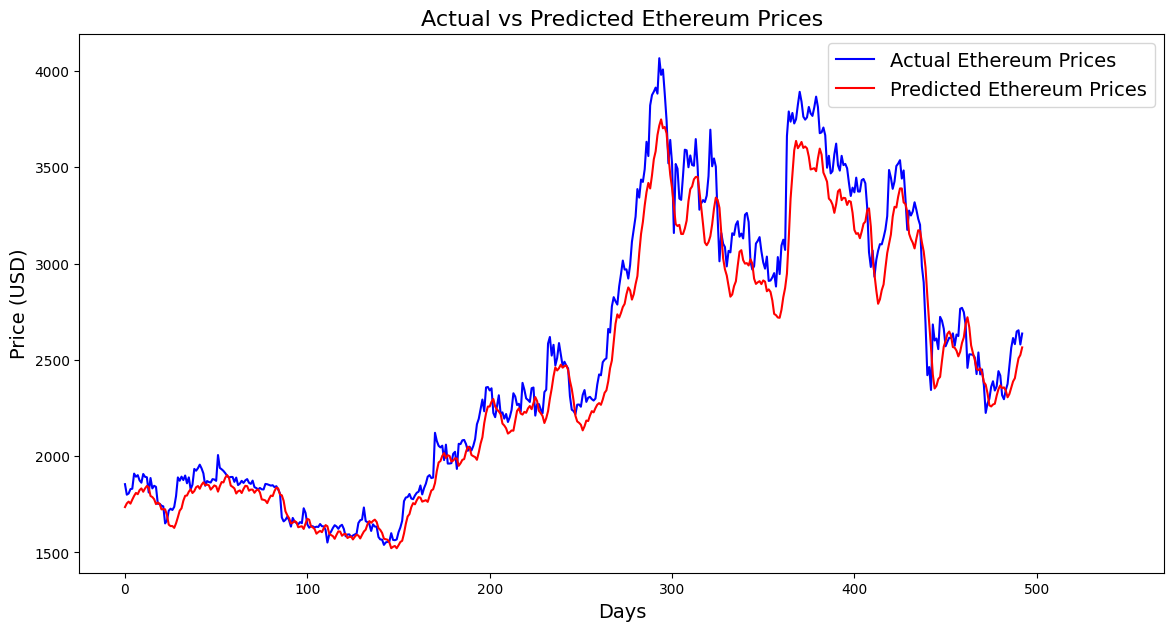

In [ ]:
y_true = inverse_scale_close(y_test, scaler, n_features=len(features))
y_pred = inverse_scale_close(model.predict(X_test).reshape(-1), scaler, n_features=len(features))

plt.figure(figsize=(14, 7))

plt.plot(y_true, label='Actual Ethereum Prices', color='blue')
plt.plot(y_pred, label='Predicted Ethereum Prices', color='red')

plt.title('Actual vs Predicted Ethereum Prices', fontsize = 16)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Price (USD)', fontsize = 14)
plt.legend(fontsize = 14)
plt.xlim(-25, 570)
plt.show()
